## Coding Exercise #0708b

### 1. Inverse transform with AutoEncoder (reduced dimensional input):

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#### 1.1. Download the MNIST data:

In [3]:
(_ , _), (mnist_test_images, _) = tf.keras.datasets.mnist.load_data()

# for mnist_test_images shape is already = [batch_size, in_height, in_width, in_channels]
mnist_test_images = mnist_test_images.astype('float32') / 255

mnist_test_images = np.expand_dims(mnist_test_images, -1).reshape((mnist_test_images.shape[0],-1))

11490434/11490434 [==============================] - 1s 0us/step


#### 1.2. Visualize the data:

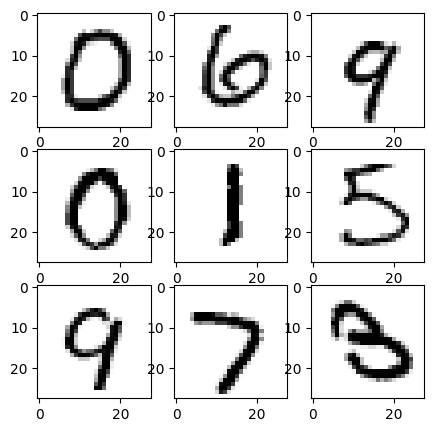

In [4]:
n_rows = 3
n_cols = 3
n_shift = 10
f, a = plt.subplots(n_rows, n_cols, figsize=(5, 5))
for i in range(n_rows):
    for j in range(n_cols):
        single_image = mnist_test_images[n_shift+i*n_cols+j].reshape(28,28)
        a[i,j].imshow(1.0-single_image, cmap='gist_gray')      # In Grayscale.
plt.show()

#### 1.3. Define an AutoEncoder model:

In [5]:
# Hyperparameters definition.
n_input = 784             # Input layers has as many nodes as the number of variables.
n_hidden = 98             # The number of nodes in the hidden layer <= targeted reduced dimension.
n_output = n_input        # The output should have the same number of nodes as the input.
learn_rate = 0.005
n_epochs = 1001

In [6]:
# Variables definition.
initializer = tf.initializers.VarianceScaling()
W1 = tf.Variable(initializer([n_input, n_hidden]), dtype=tf.float32)
W2 = tf.Variable(initializer([n_hidden, n_output]), dtype=tf.float32)
b1 = tf.Variable(tf.zeros(n_hidden))
b2 = tf.Variable(tf.zeros(n_output))

In [7]:
# AutoEncoder model definition.
class Model_AE(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    # Variables definition.
    initializer = tf.initializers.VarianceScaling(seed=123)
    self.W1 = tf.Variable(initializer([n_input, n_hidden]), dtype=tf.float32)
    self.W2 = tf.Variable(initializer([n_hidden, n_output]), dtype=tf.float32)
    self.b1 = tf.Variable(tf.zeros(n_hidden))
    self.b2 = tf.Variable(tf.zeros(n_output))

  def AE_encoder(self, X):
    return tf.matmul(X, self.W1) + self.b1                  # ReLu activation.

  def AE_decoder(self, hidden_layer):
    return tf.matmul(hidden_layer, self.W2) + self.b2

  def __call__(self, X):
    return self.AE_decoder(self.AE_encoder(X))

model_AE = Model_AE(name="model_autoencoder")

In [8]:
def loss_fn(X, y_model):
  return tf.reduce_mean(tf.square(X - y_model))             # 'X' takes the place of 'y'!!!

In [9]:
optimizer = tf.optimizers.Adam(learning_rate = learn_rate)

#### 1.4. AutoEncoder training:

In [10]:
checkpoint = tf.train.Checkpoint(model_AE)

@tf.function
def train_step(model, X):
    with tf.GradientTape(persistent=True) as tape:
        y_model = model(X)
        loss = loss_fn(X, y_model)
    gradients = tape.gradient(loss, [model.W1, model.W2, model.b1, model.b2])
    optimizer.apply_gradients(zip(gradients, [model.W1, model.W2, model.b1, model.b2]))
    return loss

# Training.
for i in range(n_epochs):
    mse = train_step(model_AE, mnist_test_images)
    if i % 100 == 0:
        print("Step : {}    ,    MSE : {:5.3f}".format(i, mse))

save_path = checkpoint.save("./autoencoder")                # Save the result.

Step : 0    ,    MSE : 0.216
Step : 100    ,    MSE : 0.021
Step : 200    ,    MSE : 0.013
Step : 300    ,    MSE : 0.009
Step : 400    ,    MSE : 0.008
Step : 500    ,    MSE : 0.007
Step : 600    ,    MSE : 0.007
Step : 700    ,    MSE : 0.006
Step : 800    ,    MSE : 0.006
Step : 900    ,    MSE : 0.006
Step : 1000    ,    MSE : 0.006


#### 1.5. Visualize the result:

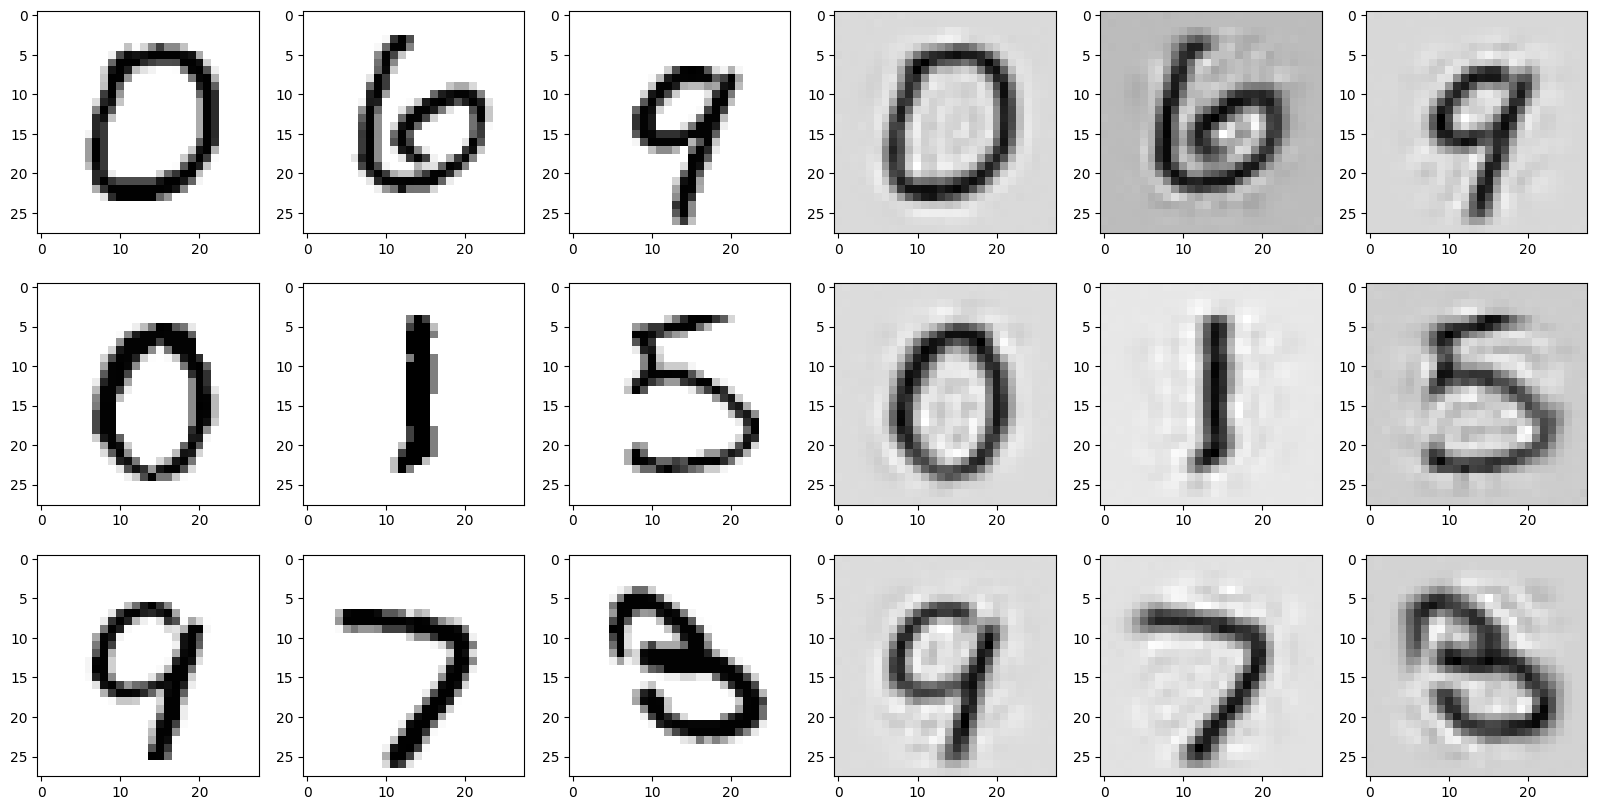

In [11]:
# Left 3x3 are the original.
# Right 3x3 are the reduced dimensional input.
n_images = n_rows*n_cols

checkpoint.restore(save_path)
X_inverse_transform = model_AE(mnist_test_images[n_shift:n_shift+n_images])      # The output is the reduced dimensional input!

f, a = plt.subplots(n_rows, 2*n_cols, figsize=(20, 10))
for i in range(n_rows):
    for j in range(n_cols):
        single_image1 = mnist_test_images[n_shift+i*n_cols+j].reshape(28,28)
        single_image2 = X_inverse_transform[i*n_cols+j].numpy().reshape(28,28)
        a[i][j].imshow(1.0-single_image1, cmap='gist_gray')             # Grayscale.
        a[i][j+n_cols].imshow(1.0-single_image2, cmap='gist_gray')      # Grayscale.
plt.show()